# DSA5204 DEEP LEARNING AND APPLICATIONS
## GROUP 18
#### Kang Mingyue A0262127L
#### Peng Hanqiu A0179035B
#### Ren Lianhai A0262042U
#### Wu Shiqi A0262031X
#### Zhang Jingguo A0262029J

<a href="https://colab.research.google.com/github/hajiao/DSA5204/blob/master/DSA5204_Project_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook aims to varify the our blocks (with the same ones in keras_cv package) and test their performance (mainly the computation speed)

# Conclusion:
  1. **@tf.function** decorator can significantly improve speed
  2. **tf.cond** and **if-else** block performes better than lambda function. Since tensorflow will change if-else structure into tf.cond one in station graph (under @tf.function decoration), their difference are little. 
  3. **Squeeze-and-Excite (SE) block**, **MBConv block** and **FusedMBConv blok**, our block out-performes keras_cv provided one in inference while **layer dropout block** keras_cv one is better.
  4. For the whole model, our model is **faster** in the training than keras_cv one
  5. The conclusion above are consistent in both **CPU** and **GPU** environment
  6. The **mix-precision** strategy (only useful in GPU) does not make much progress in acceleration while it does in toy example

In [1]:
!nvidia-smi

Tue Apr  4 16:10:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:18:00.0 Off |                  N/A |
| 32%   55C    P8    22W / 350W |      8MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:51:00.0 Off |                  N/A |
| 32%   

In [2]:
# !pip3 install keras_cv --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 KB 8.5 MB/s eta 0:00:00


In [3]:
# from dsa5204_project_utils import *
import os
# drive.mount('/content/drive')

import tensorflow as tf

#import necessary packages

from tensorflow import keras
import keras_cv
import numpy as np
import re
import copy
import matplotlib.pyplot as plt
import functools
import time

2023-04-04 16:10:50.861996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 16:10:50.922077: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [4]:
tf.config.list_physical_devices('GPU')
# tf.config.set_soft_device_placement(True)
# tf.debugging.set_log_device_placement(True)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[1], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [5]:
class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self,epoch, logs={}):
        self.starttime=time.time()
    def on_epoch_end(self,epoch, logs={}):
        self.times.append(time.time()-self.starttime)
time_callback = TimingCallback()

In [89]:
def test_running(x,y,model,batch_size=100,loss='mse',verbose=0,epochs=7):
    model.compile('sgd',loss)
    model.fit(x,y,batch_size=batch_size,epochs=epochs,verbose=verbose,callbacks=[time_callback])
    step_per_epoch=np.floor(x.shape[0]/batch_size)
    timesms=1000.*np.array(time_callback.times[1:])/step_per_epoch
    print('Average running time: %.3f ms ± %.3f ms / batch' % (np.mean(timesms),np.std(timesms)))

### Test decorator @tf.function using SquezeeandExcite(SE) block

In [8]:
class SE(keras.layers.Layer):
  def __init__(self,filters,ratio=.25,act='relu'):
    super().__init__()
    reduced_filters=max(1,int(filters*ratio))
    self.squeeze=keras.layers.Conv2D(
      reduced_filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation=act,
      kernel_initializer=keras.initializers.VarianceScaling(scale=2.,mode='fan_out')
  )
    self.excite=keras.layers.Conv2D(
      filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation='sigmoid',
      kernel_initializer=keras.initializers.VarianceScaling(scale=2.,mode='fan_out')
  )
    self.globalavgpool=keras.layers.GlobalAveragePooling2D(keepdims=True)
  @tf.function
  def call(self,inputx):
    x=self.globalavgpool(inputx)
    x=self.squeeze(x)
    x=self.excite(x)
    return inputx*x

class SE1(keras.layers.Layer):
  def __init__(self,filters,ratio=.25,act='relu'):
    super().__init__()
    reduced_filters=max(1,int(filters*ratio))
    self.squeeze=keras.layers.Conv2D(
      reduced_filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation=act
  )
    self.excite=keras.layers.Conv2D(
      filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation='sigmoid',
  )
    self.globalavgpool=keras.layers.GlobalAveragePooling2D(keepdims=True)
  def call(self,inputx):
    x=self.globalavgpool(inputx)
    x=self.squeeze(x)
    x=self.excite(x)
    return inputx*x

def se(inputx,se_filters,output_filters,act):
  se_tensor=tf.reduce_mean(inputx,[1,2],keepdims=True)
  x=keras.layers.Conv2D(
      se_filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation=act
  )(se_tensor)
  x=keras.layers.Conv2D(
      output_filters,
      kernel_size=1,
      strides=1,
      padding='same',
      activation='sigmoid',
  )(x)
  return x*inputx
  

In [5]:
tfse=keras_cv.layers.SqueezeAndExcite2D(10)
myse=SE(10)
myse1=SE1(10)


In [6]:
x=keras.Input((None,None,10))
y=se(x,2,10,'relu')
myse2=keras.Model(x,y)

2023-03-26 18:13:38.943798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 18:13:39.683006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8b:00.0, compute capability: 8.6


test the architecture

In [ ]:
x=np.random.rand(1,6,6,10)
print(np.sum(tfse(x)-myse(x)),np.sum(tfse(x)-myse1(x)),np.sum(tfse(x)-myse2(x)))
myse.set_weights(tfse.get_weights())
myse1.set_weights(tfse.get_weights())
myse2.set_weights(tfse.get_weights())
print(np.sum(tfse(x)-myse(x)),np.sum(tfse(x)-myse1(x)),np.sum(tfse(x)-myse2(x)))

0.1986579 0.28954387 0.0
0.0 0.0 0.0


In [ ]:
%timeit -n 1000 tfse(x)
%timeit -n 1000 myse(x) #@tf.function
%timeit -n 1000 myse1(x) #no decorated
%timeit -n 1000 myse2(x) #Model

1.4 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.49 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.38 ms ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.74 ms ± 35.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [6]:
x=keras.Input((None,None,32))
y=SE(32)(x)
myse=keras.Model(x,y)
x=keras.Input((None,None,32))
y=SE1(32)(x)
myse1=keras.Model(x,y)
x=keras.Input((None,None,32))
y=se(x,8,32,'relu')
myse2=keras.Model(x,y)
x=keras.Input((None,None,32))
y=keras_cv.layers.SqueezeAndExcite2D(32)(x)
tfse=keras.Model(x,y)

2023-03-26 20:44:39.446487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 20:44:40.229309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8b:00.0, compute capability: 8.6


In [7]:
x=np.random.randn(10000,32,32,32)

In [13]:
test_running(x,x,myse)
test_running(x,x,myse1)
test_running(x,x,myse2)
test_running(x,x,tfse)

Average running time: 8.062 ms ± 0.926 ms / batch
Average running time: 7.321 ms ± 1.152 ms / batch
Average running time: 7.954 ms ± 1.172 ms / batch
Average running time: 7.510 ms ± 1.109 ms / batch


Conclusion: using keras block

### Test Convolution Batchnormalization activation composite block(CBA)

In [35]:

class CBA2D_layer(keras.layers.Conv2D):
  def __init__(self,*args,kernel_initializer=keras.initializers.HeNormal(seed=5204),**kwargs):
    
    super().__init__(*args,
                     kernel_initializer=kernel_initializer,
                     **kwargs)
    self.act=self.activation
    self.activation=None
    self.bn=keras.layers.BatchNormalization()
  @tf.function
  def call(self, input, training):
    x=super().call(input)
    x=self.bn(x,training)
    x=self.act(x)
    return x

In [8]:
l=CBA2D_layer(6,(3,3),activation='relu')

In [ ]:
x=keras.Input((None,None,5))
y=keras.layers.Conv2D(6,(3,3),activation=None)(x)
y=keras.layers.BatchNormalization()(y)
y=keras.activations.relu(y)
l1=keras.Model(x,y)

In [ ]:
x=np.random.rand(2,4,4,5)
l(x),l1(x)
l1.set_weights(l.get_weights())
np.sum(l(x)!=l1(x))

0

In [ ]:
%timeit l(x) #CBAblock
%timeit l1(x) #Model

579 µs ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.14 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
x=keras.Input((None,None,32))
y=CBA2D_layer(64,(3,3),activation='relu',padding='same')(x)
cba=keras.Model(x,y)
x=keras.Input((None,None,32))
y=keras.layers.Conv2D(64,(3,3),activation=None,padding='same')(x)
y=keras.layers.BatchNormalization()(y)
y=keras.activations.relu(y)
cba1=keras.Model(x,y)

In [16]:
xx=np.random.randn(10000,32,32,32)
yy=np.random.randn(10000,32,32,64)

In [17]:
test_running(xx,yy,cba)
test_running(xx,yy,cba1)

Average running time: 10.694 ms ± 1.683 ms / batch
Average running time: 10.335 ms ± 0.995 ms / batch


Conclusion: subclass is better

### Test spatial dropout layer and if-else / tf.cond architecture

In [6]:
class drop_connect_layer(keras.layers.Layer):
  def __init__(self,survival_prob):
    super().__init__()
    self.survival_prob=survival_prob
  @tf.function
  def call(self,inputs,training):
    """Drop the entire conv with given survival probability."""
    # "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    def train_fn():
      # Compute tensor.
      batch_size = tf.shape(inputs)[0]
      binary_tensor = tf.cast(tf.random.uniform([batch_size,1,1,1])<self.survival_prob,dtype=inputs.dtype)
      # Unlike conventional way that multiply survival_prob at test time, here we
      # divide survival_prob at training time, such that no addition compute is
      # needed at test time.
      output = inputs / self.survival_prob * binary_tensor
      return output
    # return tf.cond(tf.cast(training,tf.bool),train_fn,lambda: inputs)
    if training:
      return train_fn()
    return inputs
class drop_connect_layer1(keras.layers.Layer):
  def __init__(self,survival_prob):
    super().__init__()
    self.survival_prob=survival_prob
  @tf.function
  def call(self,inputs,training=False):
    """Drop the entire conv with given survival probability."""
    # "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    def train_fn():
      # Compute tensor.
      batch_size = tf.shape(inputs)[0]
      binary_tensor = tf.cast(tf.random.uniform([batch_size,1,1,1])<self.survival_prob,dtype=inputs.dtype)
      # Unlike conventional way that multiply survival_prob at test time, here we
      # divide survival_prob at training time, such that no addition compute is
      # needed at test time.
      output = inputs / self.survival_prob * binary_tensor
      return output
    return tf.cond(tf.cast(training,tf.bool),train_fn,lambda: inputs)

In [ ]:
d=drop_connect_layer(0.1)
d1=drop_connect_layer1(0.1)
tfd=keras.layers.SpatialDropout2D(0.9)

In [ ]:
#if-else
%timeit -n 1000 d(x)
%timeit -n 1000 d(x,True)
#tf.cond
%timeit -n 1000 d1(x)
%timeit -n 1000 d1(x,True)
#tf-dropout
%timeit -n 1000 tfd(x)
%timeit -n 1000 tfd(x,True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
461 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
491 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


2023-03-01 22:36:25.550916: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_7


532 µs ± 51.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


2023-03-01 22:36:29.238594: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: cond/branch_executed/_7


1.55 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
426 µs ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
816 µs ± 174 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
x=keras.Input((None,None,32))
y=drop_connect_layer(0.8)(x)
drop=keras.Model(x,y)
x=keras.Input((None,None,32))
y=drop_connect_layer1(0.8)(x)
drop1=keras.Model(x,y)
x=keras.Input((None,None,32))
y=keras.layers.SpatialDropout2D(0.2)(x)
tfdrop=keras.Model(x,y)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-26 20:49:03.053025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 20:49:03.791703: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:8b:00.0, compute capability: 8.6


In [8]:
xx=np.random.randn(10000,32,32,32)

In [9]:
test_running(xx,xx,drop)
test_running(xx,xx,drop1)
test_running(xx,xx,tfdrop)

Average running time: 7.025 ms ± 0.395 ms / batch


2023-03-26 20:49:23.123180: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_1/drop_connect_layer1/StatefulPartitionedCall/cond/branch_executed/_10


Average running time: 7.130 ms ± 0.273 ms / batch
Average running time: 6.934 ms ± 0.218 ms / batch


Conlusion: if-else is slightly better than tf.cond, keras layer is faster in inference but slower in training

### Test which Do-nothing architecture is better

In [10]:
class testlayer1(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.f=lambda x:x
  @tf.function
  def call(self,x):
    return self.f(x)
class testlayer2(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.f2=tf.constant(True,tf.bool)
  @tf.function
  def call(self,x):
    return tf.cond(self.f2,lambda:x,lambda:x**2)
class testlayer3(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.f2=None
  @tf.function
  def call(self,x):
    if self.f2:
      return x
    return x


In [ ]:
l1=testlayer1() #baseline
l2=testlayer2() #tf.cond
l3=testlayer3() #if-else
%timeit -n 1000 l1(x)
%timeit -n 1000 l2(x)
%timeit -n 1000 l3(x)
l3.f2=tf.constant(True,tf.bool)
%timeit -n 1000 l3(x)
l3.f2=True
%timeit -n 1000 l3(x)

397 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
823 µs ± 372 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
408 µs ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
416 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
619 µs ± 212 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
x=keras.Input((None,None,32))
y=testlayer1()(x)
test1=keras.Model(x,y)
x=keras.Input((None,None,32))
y=testlayer2()(x)
test2=keras.Model(x,y)
x=keras.Input((None,None,32))
y=testlayer3()(x)
test3=keras.Model(x,y)
x=keras.Input((None,None,32))
l31=testlayer3()
l31.f2=tf.constant(True,tf.bool)
y=l31(x)
test31=keras.Model(x,y)
l32=testlayer3()
l32.f2=True
x=keras.Input((None,None,32))
y=l32(x)
test32=keras.Model(x,y)

In [12]:
xx=np.random.randn(10000,32,32,32)

In [18]:
test_running(xx,xx,test1)
test_running(xx,xx,test2)
test_running(xx,xx,test3)
test_running(xx,xx,test31)
test_running(xx,xx,test32)

Average running time: 6.576 ms ± 0.372 ms / batch
Average running time: 6.265 ms ± 0.223 ms / batch
Average running time: 6.703 ms ± 0.229 ms / batch
Average running time: 6.226 ms ± 0.302 ms / batch
Average running time: 6.304 ms ± 0.467 ms / batch


Conclusion: if-else is slightly better

### Test MBConv Block

In [9]:
'''
  The core block of the EfficientNet
  using res-block type architecture in repeated layers
  using channel-wise FC ((1x1) kernel) to expand the features
  then use depthwise Conv to get better performance than original Conv
  using Squeeze-and-Excite layer to weighted each features 
  then project to the original feature  
  could add dropout layer after SE to add regularization
'''
class MBC_Block(keras.layers.Layer):
  def __init__(self,act,args,survival_prob=1):
    super().__init__()
    filters=int(args['input_filters']*args['expand_ratio'])
    self.expandblock=None
    if args['expand_ratio']!=1:
      self.expandblock=CBA2D_layer(
            filters=filters,
            kernel_size=1,
            strides=1,
            padding='same',
            use_bias=False,
            activation=act
          )
    self.depwiseblock=DepthwiseCBA2D_layer(
      kernel_size=args['kernel_size'],
      strides=args['strides'],
      padding='same',
      use_bias=False,
      activation=act
    )
    self.conv_dropout=None
    if 'conv_dropout' in args.keys():
      if args['conv_dropout'] and args['expand_ratio'] > 1:
        self.conv_dropout=keras.layers.Dropout(args['conv_dropout'])
    if args['se_ratio']:
      self.se=SE(filters,args['se_ratio']/args['expand_ratio'],act)
    else:
      self.se=None
    self.outputblock=CBA2D_layer(
        filters=args['output_filters'],
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
        activation=None
    )
    self.residual_dropout=None
    self.residual=None
    if args['strides']==1 and args['input_filters']==args['output_filters']:
      if 1-survival_prob:
        self.residual_dropout=keras.layers.SpatialDropout2D(1-survival_prob)
      self.residual=self._residual
      
  @tf.function
  def _residual(self,x,input):
    if self.residual_dropout:
      x=self.residual_dropout(x)
    return tf.add(x,input)
  @tf.function
  def call(self,input):
    x=input
    if self.expandblock:
      x=self.expandblock(x)
    x=self.depwiseblock(x)
    if self.conv_dropout:
      x=self.conv_dropout(x)
    if self.se:
      x=self.se(x)
    x=self.outputblock(x)
    if self.residual:
      x=self.residual(x,input)
    return x

In [ ]:
args=dict(kernel_size=3,
      input_filters=4,
      output_filters=4,
      expand_ratio=3,
      se_ratio=.25,
      strides=1)

In [36]:
class DepthwiseCBA2D_layer(keras.layers.DepthwiseConv2D):
  def __init__(self,*args,depthwise_initializer=keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_out", distribution="untruncated_normal", seed=5204
),**kwargs):
    super().__init__(*args,
                     depthwise_initializer=depthwise_initializer,
                     **kwargs)
    self.act=self.activation
    self.activation=None
    self.bn=keras.layers.BatchNormalization()
  @tf.function
  def call(self, input, training):
    x=super().call(input)
    x=self.bn(x,training)
    x=self.act(x)
    return x

In [ ]:
l=MBC_Block('relu',args)
l1=keras_cv.layers.MBConvBlock(input_filters=4,output_filters=4,expand_ratio=3,
                se_ratio=.25,activation='relu',survival_probability=1)

In [ ]:
x=np.random.rand(10,40,40,4)
l1(x),l(x)
l.set_weights(l1.get_weights())
np.sum((l1(x)!=l(x)))

0

In [ ]:
l=MBC_Block('swish',args)
l1=keras_cv.layers.MBConvBlock(input_filters=4,output_filters=4,expand_ratio=3,
                se_ratio=.25,activation='swish',survival_probability=1)
x=np.random.rand(10,40,40,4)
l1(x),l(x)
l.set_weights(l1.get_weights())
np.sum(abs(l1(x)-l(x))>1e-6)

0

In [ ]:
%timeit -n 1000 l1(x) #keras-cv
%timeit -n 1000 l(x) #ours

5.11 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.07 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
args=dict(kernel_size=3,
      input_filters=32,
      output_filters=32,
      expand_ratio=3,
      se_ratio=.25,
      strides=1,
         survival_prob=0.8)

In [30]:
x=keras.Input((None,None,32))
y=MBC_Block('swish',args)(x)
myMBC=keras.Model(x,y)
x=keras.Input((None,None,32))
y=keras_cv.layers.MBConvBlock(input_filters=32,output_filters=32,expand_ratio=3,
                se_ratio=.25,activation='swish',survival_probability=0.8)(x)
tfMBC=keras.Model(x,y)

In [27]:
xx=np.random.randn(10000,32,32,32)

In [31]:
test_running(xx,xx,myMBC)
test_running(xx,xx,tfMBC)

Average running time: 13.633 ms ± 2.397 ms / batch


2023-03-26 20:55:05.072419: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/mb_conv_block_1/mb_conv_block_1drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-26 20:55:05.178342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Average running time: 14.416 ms ± 2.457 ms / batch


Conclusion: use our MBConv block

### Test FusedMBConv block

In [10]:
'''
  Another Core block of EfficientNetV2
  Using Convolution layer replacing the channel-wise FC and Depthwise Conv to reduce computation cost
  it finds that Depthwise convolutions are slow in early layers but effective in later stages
'''

class FusedMBC_Block(keras.layers.Layer):
  def __init__(self,act,args,survival_prob=1):
    super().__init__()
    filters=int(args['input_filters']*args['expand_ratio'])
    self.expandblock=None
    if args['expand_ratio']!=1:
      self.expandblock=CBA2D_layer(
            filters=filters,
            kernel_size=args['kernel_size'],
            strides=args['strides'],
            padding='same',
            use_bias=False,
            activation=act
          )
    self.conv_dropout=None
    if 'conv_dropout' in args.keys():
      if args['conv_dropout'] and args['expand_ratio'] > 1:
        self.conv_dropout=keras.layers.Dropout(args['conv_dropout'])
    if args['se_ratio']:
      self.se=SE(filters,args['se_ratio']/args['expand_ratio'],act)
    else:
      self.se=None
    self.outputblock=CBA2D_layer(
        filters=args['output_filters'],
        kernel_size=args['kernel_size'] if args['expand_ratio'] == 1 else 1,
        strides=args['strides'] if args['expand_ratio'] == 1 else 1,
        padding='same',
        use_bias=False,
        activation=act if args['expand_ratio'] == 1 else None
    )
    self.residual_dropout=None
    self.residual=None
    if args['strides']==1 and args['input_filters']==args['output_filters']:
      if 1-survival_prob:
        self.residual_dropout=keras.layers.SpatialDropout2D(1-survival_prob)
      self.residual=self._residual
      
  @tf.function
  def _residual(self,x,input):
    if self.residual_dropout:
      x=self.residual_dropout(x)
    return tf.add(x,input)
  @tf.function
  def call(self,input):
    x=input
    if self.expandblock:
      x=self.expandblock(x)
    if self.conv_dropout:
      x=self.conv_dropout(x)
    if self.se:
      x=self.se(x)
    x=self.outputblock(x)
    if self.residual:
      x=self.residual(x,input)
    return x

In [ ]:
l=FusedMBC_Block('swish',args)
l1=keras_cv.layers.FusedMBConvBlock(input_filters=4,output_filters=4,expand_ratio=3,
                se_ratio=.25,survival_probability=1)


In [ ]:
x=np.random.rand(10,40,40,4)
l1(x),l(x)
l.set_weights(l1.get_weights())
np.sum(abs(l1(x)-l(x))>1e-6)

0

In [ ]:
%timeit -n 1000 l1(x) #keras-cv
%timeit -n 1000 l(x) #ours

5.15 ms ± 515 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.55 ms ± 249 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [38]:
x=keras.Input((None,None,32))
y=FusedMBC_Block('swish',args)(x)
myfMBC=keras.Model(x,y)
x=keras.Input((None,None,32))
y=keras_cv.layers.FusedMBConvBlock(input_filters=32,output_filters=32,expand_ratio=3,
                se_ratio=.25,activation='swish',survival_probability=0.8)(x)
tffMBC=keras.Model(x,y)

In [39]:
xx=np.random.randn(10000,32,32,32)

In [40]:
test_running(xx,xx,myfMBC)
test_running(xx,xx,tffMBC)

Average running time: 12.091 ms ± 2.570 ms / batch


2023-03-26 20:56:07.806488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_15/fused_mb_conv_block_1/fused_mb_conv_block_1drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Average running time: 12.075 ms ± 2.024 ms / batch


Conclusion: use our layer

## Test full model

In [11]:
class EfficientV2base(keras.Model):
  def __init__(self,act,block_cfgs,head_filters=1280,survival_prob=0.8,dropout=None):
    super().__init__()
    self.stem=CBA2D_layer(
        filters=block_cfgs[0]['input_filters'],
        kernel_size=3,
        strides=2,
        padding='same',
        use_bias=False,
        activation=act,
        )
    
    self.blocks=[]
    for idx,block_cfg in enumerate(block_cfgs):
      if survival_prob:
        drop_rate = 1.0 - survival_prob
        survival_prob = 1.0 - drop_rate * float(idx) / len(block_cfgs)
      if block_cfg['conv_type']:
        self.blocks.append(FusedMBC_Block(act,block_cfg,survival_prob))
      else:
        self.blocks.append(MBC_Block(act,block_cfg,survival_prob))
    self.head_block=CBA2D_layer(filters=head_filters,
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
        activation=act)
    self.head_pool=keras.layers.GlobalAveragePooling2D()
    self.dropout=None
    if dropout and dropout>0 and dropout<1:
      self.dropout=keras.layers.Dropout(dropout)
  @tf.function
  def head(self,x):
    x=self.head_block(x)
    x=self.head_pool(x)
    if self.dropout:
      x=self.dropout(x)
    return x
  @tf.function
  def call(self,x):
    x=self.stem(x)
    for block in self.blocks:
      x=block(x)
    x=self.head(x)
    return x

In [12]:
act=keras.activations.swish
depth_divisor=8
min_depth=8
survival_prob=0.8
dropout=0.2
nclasses=10
conv_dropout=None

#b0_config
v2_base_block = [ # The baseline config for v2 models.
'r1_k3_s1_e1_i32_o16_c1',
'r2_k3_s2_e4_i16_o32_c1',
'r2_k3_s2_e4_i32_o48_c1',
'r3_k3_s2_e4_i48_o96_se0.25',
'r5_k3_s1_e6_i96_o112_se0.25',
'r8_k3_s2_e6_i112_o192_se0.25',
]


In [13]:
def decode_block_cfg(s):
  ops = s.split('_')
  options = {}
  for op in ops:
    splits = re.split(r'(\d.*)', op)
    if len(splits) >= 2:
      key, value = splits[:2]
      options[key] = value
  return dict(
      kernel_size=int(options['k']),
      num_repeat=int(options['r']),
      input_filters=int(options['i']),
      output_filters=int(options['o']),
      expand_ratio=int(options['e']),
      se_ratio=float(options['se']) if 'se' in options else None,
      strides=int(options['s']),
      conv_type=int(options['c']) if 'c' in options else 0,
  )

In [14]:
'''
decode the blocks config above for latter model construction 
'''
def decode_cfgs(cfgs):
  block_cfgs=[]
  for s in cfgs:
    block_cfg=decode_block_cfg(s)
    block_cfgs.append(copy.copy(block_cfg))
    if block_cfg['num_repeat']>1:
      block_cfg['input_filters']=block_cfg['output_filters']
      block_cfg['strides']=1
    for _ in range(block_cfg['num_repeat']-1):
      block_cfgs.append(copy.copy(block_cfg))
  return block_cfgs

In [37]:
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block))

In [38]:
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [17]:
truemodel=keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=10,
    classifier_activation="softmax",
    include_preprocessing=False,
)

In [18]:
x=truemodel.output
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(10,activation='softmax')(x)
tf_model=keras.Model(inputs=truemodel.input,outputs=x)
tf_model.compile(keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=[keras.metrics.categorical_accuracy])

In [21]:
efficientv2_base.summary()

Model: "efficient_v2base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cba2d_layer (CBA2D_layer)   multiple                  992       
                                                                 
 fused_mbc__block (FusedMBC_  multiple                 4672      
 Block)                                                          
                                                                 
 fused_mbc__block_1 (FusedMB  multiple                 11648     
 C_Block)                                                        
                                                                 
 fused_mbc__block_2 (FusedMB  multiple                 41600     
 C_Block)                                                        
                                                                 
 fused_mbc__block_3 (FusedMB  multiple                 43712     
 C_Block)                                         

In [15]:
v2_base_block_modified = [ # The baseline config for v2 models.
'r1_k3_s1_e1_i32_o16_c1',
'r1_k3_s1_e4_i16_o32_c1',
'r1_k3_s1_e4_i32_o48_c1',
'r2_k3_s2_e4_i48_o96_se0.25',
'r2_k3_s1_e6_i96_o112_se0.25',
'r5_k3_s2_e6_i112_o192_se0.25',
]

In [16]:
efficientv2_base=EfficientV2base(keras.activations.gelu,decode_cfgs(v2_base_block_modified))

In [18]:
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)
efficientv2_base.summary()

Model: "efficient_v2base_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cba2d_layer_43 (CBA2D_layer  multiple                 992       
 )                                                               
                                                                 
 fused_mbc__block_5 (FusedMB  multiple                 4672      
 C_Block)                                                        
                                                                 
 fused_mbc__block_6 (FusedMB  multiple                 11648     
 C_Block)                                                        
                                                                 
 fused_mbc__block_7 (FusedMB  multiple                 43712     
 C_Block)                                                        
                                                                 
 mbc__block_16 (MBC_Block)   multiple           

# Test kernel weights initialized distribution

## using modified initialization

In [23]:
regex=r'.*kernel:.*$'
kernel_match=re.compile(regex)

In [39]:
kernelmeans=[np.mean(w) for w in truemodel.trainable_weights if kernel_match.match(w.name)]
kernelvars=[np.var(w) for w in truemodel.trainable_weights if kernel_match.match(w.name)]
mykernelmeans=[np.mean(w) for w in efficientv2_base.trainable_weights if kernel_match.match(w.name)]
mykernelvars=[np.var(w) for w in efficientv2_base.trainable_weights if kernel_match.match(w.name)]

Text(0.5, 1.0, 'distribution of weights standard deviation')

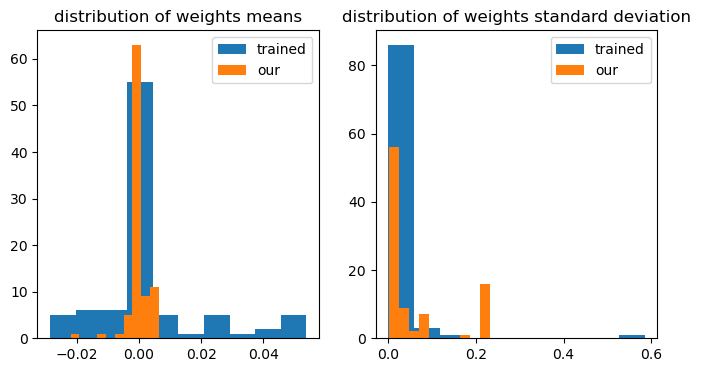

In [40]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(kernelmeans)
plt.hist(mykernelmeans)
plt.legend(["trained","our"])
plt.title('distribution of weights means')
plt.subplot(122)
plt.hist(kernelvars)
plt.hist(mykernelvars)
plt.legend(["trained","our"])
plt.title('distribution of weights standard deviation')

In [22]:
def avgnorm(x):
    return np.mean(tf.norm(tf.reshape(x,[x.shape[0],-1]),axis=-1))
def avgrelnorm(x):
    return avgnorm(x)/np.sqrt(np.prod(x.shape[1:]))

In [41]:
xnorm=[]
xrelnorm=[]
x=tf.random.uniform((1000,32,32,3))
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.stem(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
for block in efficientv2_base.blocks:
    x=block(x)
    xnorm.append(avgnorm(x))
    xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.head(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))

Text(0.5, 1.0, 'output of each block under modified initial weight ')

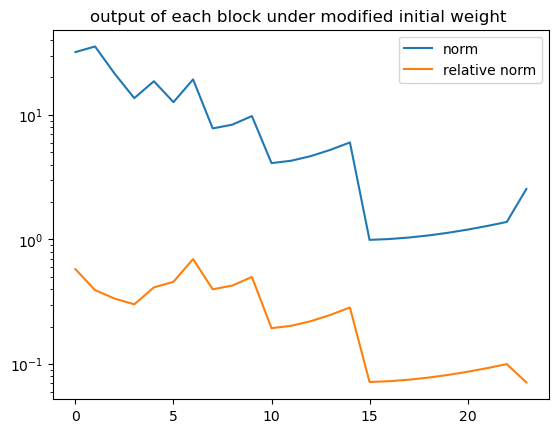

In [42]:
plt.plot(xnorm)
plt.plot(xrelnorm)
plt.legend(["norm",'relative norm'])
plt.yscale('log')
plt.title('output of each block under modified initial weight ')

### Verify model output scale

In [57]:
x=tf.random.uniform((1000,32,32,3))
print("avg input norm: {:.4f}, avg true model output norm: {:.4f}, avg our model output norm: {:.4f}".format(tf.reduce_mean(tf.norm(tf.reshape(x,[1000,-1]),axis=-1)).numpy(),
      tf.reduce_mean(tf.norm(tf.reshape(truemodel(x),[1000,-1]),axis=-1)).numpy(),
      tf.reduce_mean(tf.norm(tf.reshape(efficientv2_base(x),[1000,-1]),axis=-1)).numpy()))

avg input norm: 31.9954, avg true model output norm: 6.4552, avg our model output norm: 2.1542


## using default initialization

In [7]:
# class DepthwiseCBA2D_layer_default_initialization(keras.layers.DepthwiseConv2D):
class DepthwiseCBA2D_layer(keras.layers.DepthwiseConv2D):
  def __init__(self,*args,**kwargs):
    super().__init__(*args,
                     **kwargs)
    self.act=self.activation
    self.activation=None
    self.bn=keras.layers.BatchNormalization()
  @tf.function
  def call(self, input, training):
    x=super().call(input)
    x=self.bn(x,training)
    x=self.act(x)
    return x

# class CBA2D_layer_default_initialization(keras.layers.Conv2D):
class CBA2D_layer(keras.layers.Conv2D):
  def __init__(self,*args,**kwargs):
    
    super().__init__(*args,
                     **kwargs)
    self.act=self.activation
    self.activation=None
    self.bn=keras.layers.BatchNormalization()
  @tf.function
  def call(self, input, training):
    x=super().call(input)
    x=self.bn(x,training)
    x=self.act(x)
    return x

In [21]:
efficientv2_base_default_initialization=EfficientV2base(act,decode_cfgs(v2_base_block))
inputx=keras.Input((None,None,3))
x=efficientv2_base_default_initialization(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [24]:
kernelmeans=[np.mean(w) for w in truemodel.trainable_weights if kernel_match.match(w.name)]
kernelvars=[np.var(w) for w in truemodel.trainable_weights if kernel_match.match(w.name)]
mykernelmeans=[np.mean(w) for w in efficientv2_base.trainable_weights if kernel_match.match(w.name)]
mykernelvars=[np.var(w) for w in efficientv2_base.trainable_weights if kernel_match.match(w.name)]

Text(0.5, 1.0, 'distribution of weights standard deviation')

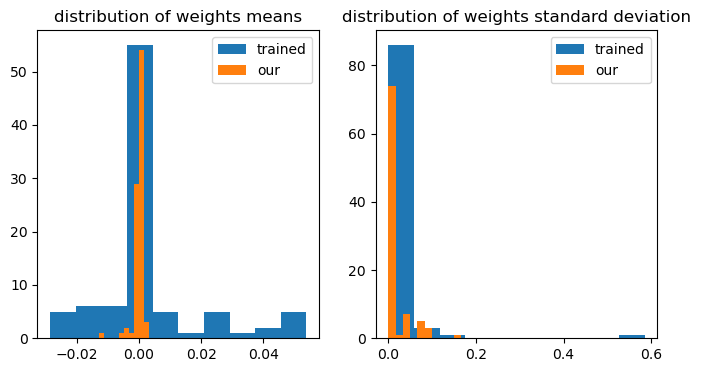

In [25]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.hist(kernelmeans)
plt.hist(mykernelmeans)
plt.legend(["trained","our"])
plt.title('distribution of weights means')
plt.subplot(122)
plt.hist(kernelvars)
plt.hist(mykernelvars)
plt.legend(["trained","our"])
plt.title('distribution of weights standard deviation')

In [26]:
xnorm=[]
xrelnorm=[]
x=tf.random.uniform((1000,32,32,3))
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.stem(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
for block in efficientv2_base.blocks:
    x=block(x)
    xnorm.append(avgnorm(x))
    xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.head(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))

2023-04-04 16:13:17.253244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


Text(0.5, 1.0, 'output of each block under default initial weight ')

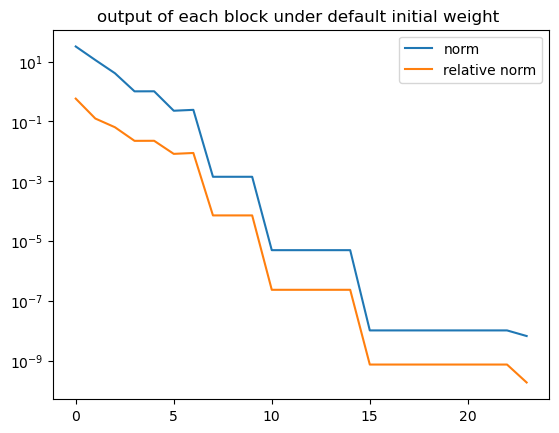

In [27]:
plt.plot(xnorm)
plt.plot(xrelnorm)
plt.legend(["norm",'relative norm'])
plt.yscale('log')
plt.title('output of each block under default initial weight ')

### Verify model output scale

In [92]:
x=tf.random.uniform((1000,32,32,3))
print("avg input norm: {:.4f}, avg true model output norm: {:.4f}, avg our model output norm: {:.4f}".format(tf.reduce_mean(tf.norm(tf.reshape(x,[1000,-1]),axis=-1)).numpy(),
      tf.reduce_mean(tf.norm(tf.reshape(truemodel(x),[1000,-1]),axis=-1)).numpy(),
      tf.reduce_mean(tf.norm(tf.reshape(efficientv2_base(x),[1000,-1]),axis=-1)).numpy()))

avg input norm: 31.9976, avg true model output norm: 6.4543, avg our model output norm: 0.0000


# Test model structure

In [22]:
# data = keras.datasets.cifar10.load_data()
# x_train, y_train, x_test, y_test=data[0][0],data[0][1],data[1][0],data[1][1]
model_path = './saved_model'
data=np.load(os.path.join(model_path,'data.npz'))
x_train, y_train, x_test, y_test=data['x_train'],data['y_train'],data['x_test'],data['y_test']
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [43]:
#compare the size of our model and provided model for varifying model architecture
try:
  for w1,w2 in zip(tf_model.trainable_weights,Mymodel.trainable_weights):
    assert w1.shape==w2.shape
  print('same shape')
except:
  print('shape different')

same shape


In [44]:
for mw,w in zip(Mymodel.trainable_weights,tf_model.trainable_weights):
    # print(np.sum(abs(mw-w)))
    mw.assign(w)

In [45]:
otherws=[w for w in tf_model.weights if not w.trainable]
myotherws=[w for w in Mymodel.weights if not w.trainable]

In [46]:
for mw,w in zip(myotherws,otherws):
    # print(mw.shape,w.shape)
    mw.assign(w)

In [47]:
#compare the size of our model and provided model for varifying model architecture
try:
  for w1,w2 in zip(tf_model.trainable_weights,Mymodel.trainable_weights):
    assert np.sum(abs(w1-w2))<1e-8
  print('same weight')
except:
  print('different weight')

same weight


In [48]:
otherws=[w for w in tf_model.weights if not w.trainable]
myotherws=[w for w in Mymodel.weights if not w.trainable]

In [49]:
#compare the size of our model and provided model for varifying model architecture
try:
  for w1,w2 in zip(myotherws,otherws):
    assert np.sum(abs(w1-w2))<1e-8
  print('same weight')
except:
  print('different weight')

same weight


In [50]:
x=tf.random.uniform((1000,32,32,3))

In [51]:
xnorm=[]
xrelnorm=[]
x=tf.random.uniform((1000,32,32,3))
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.stem(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
for block in efficientv2_base.blocks:
    x=block(x)
    xnorm.append(avgnorm(x))
    xrelnorm.append(avgrelnorm(x))
x=efficientv2_base.head(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))

Text(0.5, 1.0, 'output of each block under trained weight ')

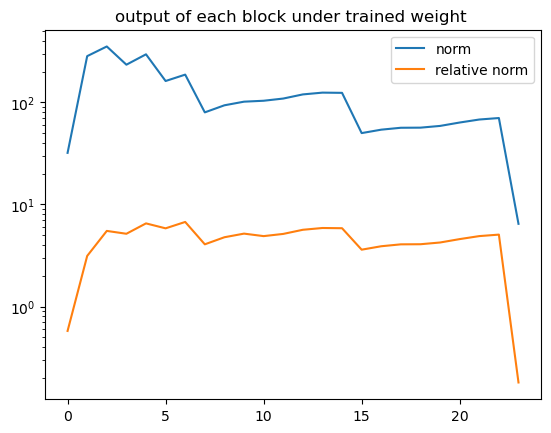

In [52]:
plt.plot(xnorm)
plt.plot(xrelnorm)
plt.legend(["norm",'relative norm'])
plt.yscale('log')
plt.title('output of each block under trained weight ')

### Verify model output

In [125]:
x=tf.random.uniform((1000,32,32,3))
print("output norm difference {:.4e}".format(
      tf.reduce_mean(tf.norm(tf.reshape(tf_model(x)-Mymodel(x),[1000,-1]),axis=-1)).numpy()))

output norm difference 8.0627e-02


In [122]:
tf_model(x).shape

TensorShape([1000, 10])

In [123]:
Mymodel(x).shape

TensorShape([1000, 10])

## Test training speed

In [48]:
inputx=keras.Input((None,None,3))
x=keras_cv.models.EfficientNetV2B0(include_rescaling=False,include_top=False,pooling='avg')(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
tfmodel=keras.Model(inputs=inputx,outputs=x)

In [49]:
xx=np.random.randn(10000,32,32,3)
yy=np.random.rand(10000,10)

In [50]:
test_running(xx,yy,Mymodel)
test_running(xx,yy,tfmodel)

Average running time: 54.864 ms ± 55.860 ms / batch


2023-03-26 21:02:38.000888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_18/model_17/block2b_/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Average running time: 47.267 ms ± 45.911 ms / batch


Conclusion: use our model

### Test mixed precision policy

In [51]:
keras.mixed_precision.set_global_policy('mixed_float16')
inputx=keras.Input(shape=(32, 32, 3))
x=keras.layers.Conv2D(
        filters=128,
        kernel_size=3,
        strides=2,
        padding='same',
        )(inputx)
BN=keras.layers.BatchNormalization()
x=BN(x)
x=keras.layers.SpatialDropout2D(0.2)(x)
x=act(x)
x=keras.layers.Conv2D(
        filters=1600,
        kernel_size=3,
        strides=2,
        padding='same',
        )(x)
BN1=keras.layers.BatchNormalization()
x=BN1(x)
x=act(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(10,activation='softmax')(x)
contrast_model=keras.Model(inputs=inputx,outputs=x)
contrast_model.compile(keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=[keras.metrics.categorical_accuracy])

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [52]:
xx=np.random.randn(10000,32,32,3)
yy=np.random.rand(10000,10)

In [53]:
test_running(xx,yy,contrast_model)

Average running time: 8.212 ms ± 4.768 ms / batch


In [54]:
keras.mixed_precision.set_global_policy('float32')
inputx=keras.Input(shape=(32, 32, 3))
x=inputx
# x=rand_augment(x)
# x=keras.layers.Lambda(lambda x: tf.cast(x,tf.float32)/255.)(x)
x=keras.layers.Conv2D(
        filters=128,
        kernel_size=3,
        strides=2,
        padding='same',
        )(x)
BN=keras.layers.BatchNormalization()
x=BN(x)
x=keras.layers.SpatialDropout2D(0.2)(x)
x=act(x)
x=keras.layers.Conv2D(
        filters=1600,
        kernel_size=3,
        strides=2,
        padding='same',
        )(x)
BN1=keras.layers.BatchNormalization()
x=BN1(x)
x=act(x)
x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(10,activation='softmax')(x)
contrast_model=keras.Model(inputs=inputx,outputs=x)
contrast_model.compile(keras.optimizers.Adam(),loss=keras.losses.CategoricalCrossentropy(),metrics=[keras.metrics.categorical_accuracy])

In [55]:
xx=np.random.randn(10000,32,32,3)
yy=np.random.rand(10000,10)

In [56]:
test_running(xx,yy,contrast_model)

2023-03-26 21:07:59.749959: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_20/spatial_dropout2d_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Average running time: 9.961 ms ± 3.067 ms / batch


In [57]:
keras.mixed_precision.set_global_policy('mixed_float16')
efficientv2_base=EfficientV2base(act,decode_cfgs(v2_base_block))

In [58]:
inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [59]:
test_running(xx,yy,Mymodel)

Average running time: 62.085 ms ± 64.276 ms / batch


**slower insteaded** conclusion: not use mixed precision

In [113]:
keras.mixed_precision.set_global_policy('float32')

# Test data preprocessing

In [61]:
# data = keras.datasets.cifar10.load_data()
# x_train, y_train, x_test, y_test=data[0][0],data[0][1],data[1][0],data[1][1]
model_path = './saved_model'
data=np.load(os.path.join(model_path,'data.npz'))
x_train, y_train, x_test, y_test=data['x_train'],data['y_train'],data['x_test'],data['y_test']
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [62]:
def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}

def load_dataset():
    return tf.data.Dataset.from_tensor_slices(dict(images=x_train,labels=tf.cast(y_train,tf.float32))).batch(128)
train_dataset = load_dataset()

In [75]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()
    
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

AUTOTUNE=tf.data.AUTOTUNE
train_dataset =  load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

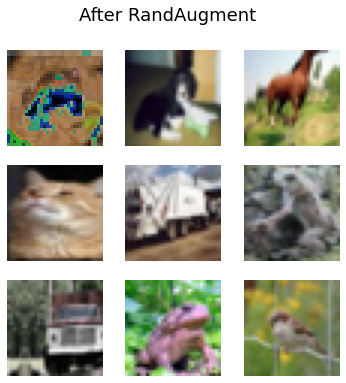

In [26]:
visualize_dataset(train_dataset, title="After RandAugment")

In [84]:
'''
function to get the augmentation pipeline
type of augmentations are same of used in origin code
it is good for augmentation functions to run under default number range (0, 255)
  since the change of number range is imcompatable for some parameter initializers (maybe is a bug)
'''
def Set_levels(level,ag_per_image=3,ag_rate=1.0,_MAX_LEVEL = 10.):
  factor=level/_MAX_LEVEL
  layers=keras_cv.layers.RandAugment.get_standard_policy(value_range=(0, 255), magnitude=factor, magnitude_stddev=0.3)
  layers+=[keras_cv.layers.RandomRotation(factor/5.),
      keras_cv.layers.Solarization((0,255)), #invert
      keras_cv.layers.Solarization((0,255),threshold_factor=layers[2].threshold_factor,addition_factor=keras_cv.ConstantFactorSampler(0)),
      keras_cv.layers.RandomSharpness(factor,(0,255)),
      keras_cv.layers.RandomCutout((0.1*factor,0.2*factor),(0.1*factor,0.2*factor)),
      keras_cv.layers.Posterization((0,255),tf.cast(tf.maximum(1,int(factor*4)),tf.uint8))]

  return keras_cv.layers.RandomAugmentationPipeline(layers,ag_per_image,ag_rate)


'''
function to implement augmentation and then scale to (0,1)
'''
def apply_my_rand_augment(inputs,ag_pipeline): #image,label
  inputs["images"] = ag_pipeline(inputs["images"])
  return inputs

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()
def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples

In [65]:
import functools

In [85]:
AUTOTUNE = tf.data.AUTOTUNE
ag_pipeline=Set_levels(1)
preparing=functools.partial(apply_my_rand_augment,ag_pipeline=ag_pipeline)

In [86]:
train_ds=load_dataset().map(preparing, num_parallel_calls=AUTOTUNE)

In [87]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)/255.
    return images, labels

def preprocess_for_model2(inputs):
    images, labels = inputs["images"], inputs["labels"]
    return images, labels

train_dataset = (
    load_dataset()
    .map(preparing, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)
# train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
# train_dataset = train_dataset.prefetch(AUTOTUNE)

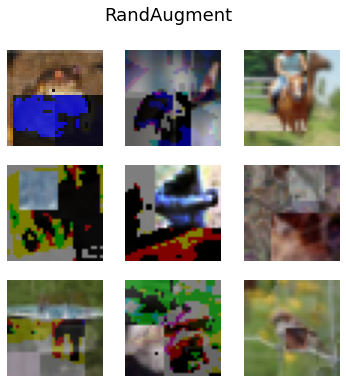

In [40]:
visualize_dataset(train_dataset, title="RandAugment")

In [88]:
resize_layer=tf.keras.layers.Resizing(40,40, interpolation="bilinear",)
def apply_resize_layer(samples):
    samples["images"] = resize_layer(samples["images"])
    return preparing(samples)

train_dataset = (
    load_dataset()
    .map(apply_resize_layer, num_parallel_calls=AUTOTUNE)
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)
# train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.prefetch(AUTOTUNE)

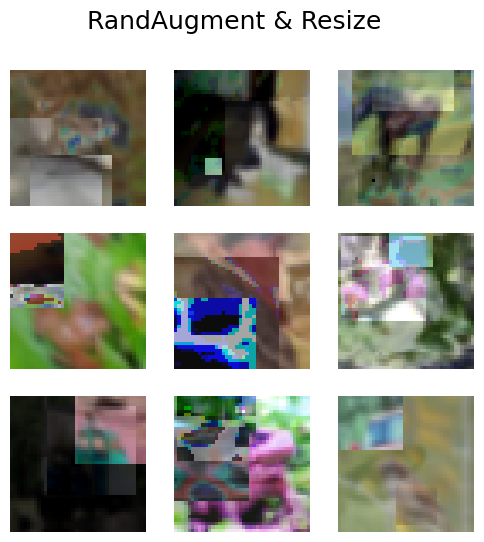

In [89]:
visualize_dataset(train_dataset, title="RandAugment & Resize")

In [96]:
def test_running_ds(dataset,model,steps_per_epoch=100,loss='mse',verbose=0,epochs=7):
    model.compile('sgd',loss)
    model.fit(dataset.repeat(),steps_per_epoch=steps_per_epoch,epochs=epochs,verbose=verbose,callbacks=[time_callback])
    timesms=1000.*np.array(time_callback.times)/steps_per_epoch
    print('Average running time: %.3f ms ± %.3f ms / batch' % (np.mean(timesms),np.std(timesms)))

In [92]:
train_dataset_raw = (
    load_dataset()
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)
train_dataset_aug = (
    load_dataset()
    .map(apply_resize_layer, num_parallel_calls=AUTOTUNE)
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

In [97]:
test_running_ds(train_dataset_raw,Mymodel)
test_running_ds(train_dataset_aug,Mymodel)

Average running time: 73.894 ms ± 40.399 ms / batch
Average running time: 278.596 ms ± 72.998 ms / batch


Not good, not used?

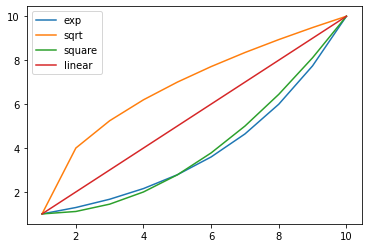

In [34]:
x=np.arange(1,11)
y1=1+np.sqrt((x-1)/9)*9
y2=1+((x-1)/9)**2*9
y=np.exp(np.log(10)*(x-1)/9)
plt.plot(x,y,x,y1,x,y2,x,x)
plt.legend(['exp','sqrt','square','linear'])

# Test modified blocks

In [58]:

'''modified MBC_Block from ConvNeXt:
    less normalization
    less activation
    Moving up conv layer. (inverted bottlenecks)
'''
class Modified_MBC_Block(keras.layers.Layer):
  def __init__(self,act,args,survival_prob=1,layer_scale=1e-6):
    super().__init__()
    filters=int(args['input_filters']*args['expand_ratio'])
    self.expandblock=None
    if args['expand_ratio']!=1:
      self.expandblock=keras.layers.Conv2D(
            filters=filters,
            kernel_size=1,
            strides=1,
            padding='same',
            use_bias=False,
            activation=None
          )
    self.depwiseblock=keras.layers.DepthwiseConv2D(
      kernel_size=args['kernel_size'],
      strides=1,
      padding='same',
      use_bias=False,
      activation=None
    )
    self.conv_dropout=None
    if 'conv_dropout' in args.keys():
      if args['conv_dropout'] and args['expand_ratio'] > 1:
        self.conv_dropout=keras.layers.Dropout(args['conv_dropout'])
    if args['se_ratio']:
      self.se=SE(filters,args['se_ratio']/args['expand_ratio'],act)
    else:
      self.se=None
    self.outputblock=keras.layers.Conv2D(
        filters=args['output_filters'],
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
        activation=act
    )
    
    self.residual_dropout=None
    self.use_residual=None
    if args['input_filters']==args['output_filters'] or args['strides']>1:
      if 1-survival_prob:
        self.residual_dropout=keras.layers.SpatialDropout2D(1-survival_prob)
      self.use_residual=tf.constant(True,tf.bool)
    
    self.downsample=None
    if args['strides']>1:
        self.downsample_LN=keras.layers.LayerNormalization(epsilon=1e-6)
        self.downsample=keras.layers.Conv2D(
            filters=args['output_filters'],
            kernel_size=2,
            strides=2,
            activation=None
        )
    self.act=self.outputblock.activation
    self.outputblock.activation=None
    self.LN=keras.layers.LayerNormalization(epsilon=1e-6)
    if self.use_residual:
        self.scale=tf.Variable(layer_scale * tf.ones((args['output_filters'],)),name=self.outputblock.name+'_scale')
    
  def residual(self,x,input):
    if self.residual_dropout:
      x=self.residual_dropout(x)
    return tf.add(self.scale*x,input)
  @tf.function
  def call(self,input):
    if self.downsample:
        input=self.downsample_LN(input)
        input=self.downsample(input)
    x=input
    x=self.depwiseblock(x)
    x=self.LN(x)
    if self.conv_dropout:
      x=self.conv_dropout(x)
    if self.expandblock:
      x=self.expandblock(x)
    if self.se:
      x=self.se(x)
    x=self.act(x)
    x=self.outputblock(x)
    if self.use_residual:
      x=self.residual(x,input)
    return x

In [59]:
args=dict(kernel_size=3,
      input_filters=4,
      output_filters=4,
      expand_ratio=3,
      se_ratio=.25,
      strides=1)

In [60]:
l=MBC_Block('swish',args)
l1=Modified_MBC_Block('gelu',args)


In [61]:
x=np.random.rand(10,40,40,4)

In [62]:
%timeit -n 1000 l1(x) #modified
%timeit -n 1000 l(x) #origin

1.39 ms ± 82.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.13 ms ± 65.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [63]:
args=dict(kernel_size=3,
      input_filters=32,
      output_filters=32,
      expand_ratio=3,
      se_ratio=.25,
      strides=1,
         survival_prob=0.8)

In [64]:
x=keras.Input((None,None,32))
y=MBC_Block('swish',args)(x)
myMBC=keras.Model(x,y)
x=keras.Input((None,None,32))
y=Modified_MBC_Block('gelu',args)(x)
myModifiedMBC=keras.Model(x,y)

In [65]:
xx=np.random.randn(10000,32,32,32)

In [66]:
test_running(xx,xx,myMBC)
test_running(xx,xx,myModifiedMBC)

2023-04-04 16:30:36.647786: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbcec015bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 16:30:36.647814: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-04-04 16:30:36.694680: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Average running time: 12.234 ms ± 4.358 ms / batch
Average running time: 12.196 ms ± 2.221 ms / batch


In [67]:
'''
 modified FusedMBC_Block from ConvNeXt:
    less normalization
    less activation
    Moving up depthwise conv layer. (inverted bottlenecks)
'''

class Modified_FusedMBC_Block(keras.layers.Layer):
  def __init__(self,act,args,survival_prob=1,layer_scale=1e-6):
    super().__init__()
    filters=int(args['input_filters']*args['expand_ratio'])
    self.expandblock=None
    if args['expand_ratio']!=1:
      self.expandblock=keras.layers.Conv2D(
            filters=filters,
            kernel_size=args['kernel_size'],
            strides=1,
            padding='same',
            use_bias=False,
            activation=None
          )
    self.conv_dropout=None
    if 'conv_dropout' in args.keys():
      if args['conv_dropout'] and args['expand_ratio'] > 1:
        self.conv_dropout=keras.layers.Dropout(args['conv_dropout'])
    if args['se_ratio']:
      self.se=SE(filters,args['se_ratio']/args['expand_ratio'],act)
    else:
      self.se=None
    self.outputblock=keras.layers.Conv2D(
        filters=args['output_filters'],
        kernel_size=args['kernel_size'] if args['expand_ratio'] == 1 else 1,
        strides=args['strides'] if args['expand_ratio'] == 1 else 1,
        padding='same',
        use_bias=False,
        activation=act
    )
    self.residual_dropout=None
    self.use_residual=None
    if args['strides']>1 or args['input_filters']==args['output_filters']:
      if 1-survival_prob:
        self.residual_dropout=keras.layers.SpatialDropout2D(1-survival_prob)
      self.use_residual=tf.constant(True,tf.bool)
     
    self.downsample=None
    if args['strides']>1:
        self.downsample_LN=keras.layers.LayerNormalization(epsilon=1e-6)
        self.downsample=keras.layers.Conv2D(
            filters=args['output_filters'],
            kernel_size=2,
            strides=2,
            activation=None
        )
    self.act=self.outputblock.activation
    self.outputblock.activation=None
    self.LN=keras.layers.LayerNormalization(epsilon=1e-6)
    if self.use_residual:
        self.scale=tf.Variable(layer_scale * tf.ones((args['output_filters'],)),name=self.outputblock.name+'_scale')

  def residual(self,x,input):
    if self.residual_dropout:
      x=self.residual_dropout(x)
    return tf.add(self.scale*x,input)
  @tf.function
  def call(self,input):
    if self.downsample:
        input=self.downsample_LN(input)
        input=self.downsample(input)
    x=input
    if self.expandblock:
      x=self.expandblock(x)
    x=self.LN(x)
    if self.conv_dropout:
      x=self.conv_dropout(x)
    if self.se:
      x=self.se(x)
    x=self.act(x)
    x=self.outputblock(x)
    if self.use_residual:
      x=self.residual(x,input)
    return x

### varify block function

In [68]:
args=dict(kernel_size=7,
      input_filters=4,
      output_filters=4,
      expand_ratio=3,
      se_ratio=.25,
      strides=1)
act=keras.activations.gelu

In [69]:
l=Modified_FusedMBC_Block(act,args)
l1=Modified_MBC_Block(act,args)

In [70]:
x=np.random.rand(10,40,40,4)
l1(x).shape,l(x).shape

(TensorShape([10, 40, 40, 4]), TensorShape([10, 40, 40, 4]))

### test running speed

In [71]:
%timeit -n 1000 l1(x) #modified
%timeit -n 1000 l(x) #origin

1.3 ms ± 30.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.3 ms ± 52.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [72]:
args=dict(kernel_size=3,
      input_filters=32,
      output_filters=32,
      expand_ratio=3,
      se_ratio=.25,
      strides=1,
         survival_prob=0.8)

In [73]:
x=keras.Input((None,None,32))
y=FusedMBC_Block('swish',args)(x)
myfMBC=keras.Model(x,y)
x=keras.Input((None,None,32))
y=Modified_FusedMBC_Block('gelu',args)(x)
myModifiedfMBC=keras.Model(x,y)

In [74]:
xx=np.random.randn(10000,32,32,32)

In [75]:
test_running(xx,xx,myfMBC)
test_running(xx,xx,myModifiedfMBC)

Average running time: 9.891 ms ± 1.857 ms / batch
Average running time: 15.110 ms ± 1.810 ms / batch


# Test modified structure

In [76]:
'''
structure modified from ConvNeXt:
    1:1:3:1 stage ratio, 
    7x7 kernel,  5x5 instead
    more filters, 
    only use depthwise convolution
    
'''
v2_base_block_modified3 = [
'r3_k7_s1_e4_i16_o32_c1',
'r3_k7_s2_e4_i32_o48_c1',
'r9_k7_s2_e4_i48_o96_se0.25_c0',
'r3_k7_s1_e4_i96_o180_se0.25_c0',
]

In [77]:
class Modified_EfficientV2base(keras.Model):
  def __init__(self,act,block_cfgs,head_filters=1280,survival_prob=0.8,dropout=None,pooling='avg'):
    super().__init__()
    self.stem=keras.layers.Conv2D(
        filters=block_cfgs[0]['input_filters'],
        kernel_size=4,
        strides=2,
        padding='same',
        use_bias=False,
        activation=None,
        )
    
    self.blocks=[]
    for idx,block_cfg in enumerate(block_cfgs):
      if survival_prob:
        drop_rate = 1.0 - survival_prob
        survival_prob = 1.0 - drop_rate * float(idx) / len(block_cfgs)
      if block_cfg['conv_type']:
        self.blocks.append(Modified_FusedMBC_Block(act,block_cfg,survival_prob))
      else:
        self.blocks.append(Modified_MBC_Block(act,block_cfg,survival_prob))
    if pooling=='avg':
      self.head_pool=keras.layers.GlobalAveragePooling2D()
    elif pooling=='max':
      self.head_pool=keras.layers.GlobalMaxPool2D()
    else:
      self.head_pool=keras.layers.Flatten()
    self.dropout=None
    if dropout and dropout>0 and dropout<1:
      self.dropout=keras.layers.Dropout(dropout)    
    self.head_block=keras.layers.Conv2D(filters=head_filters,
        kernel_size=1,
        strides=1,
        padding='same',
        use_bias=False,
        activation=act)
    self.head_LN=keras.layers.LayerNormalization(epsilon=1e-6)
    
  def head(self,x):
    x=self.head_block(x)
    if self.dropout:
      x=self.dropout(x)
    x=self.head_pool(x)
    x=self.head_LN(x)
    return x
  @tf.function
  def call(self,x):
    x=self.stem(x)
    for block in self.blocks:
      x=block(x)
    x=self.head(x)
    return x

In [78]:
modified_efficientv2_base=Modified_EfficientV2base(act,decode_cfgs(v2_base_block_modified3),head_filters=1280)
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [79]:
modified_efficientv2_base.summary()

Model: "modified__efficient_v2base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         multiple                  768       
                                                                 
 modified__fused_mbc__block_  multiple                 52352     
 2 (Modified_FusedMBC_Block)                                     
                                                                 
 modified__fused_mbc__block_  multiple                 205088    
 3 (Modified_FusedMBC_Block)                                     
                                                                 
 modified__fused_mbc__block_  multiple                 205088    
 4 (Modified_FusedMBC_Block)                                     
                                                                 
 modified__fused_mbc__block_  multiple                 313760    
 5 (Modified_FusedMBC_Block)            

In [80]:
xnorm=[]
xrelnorm=[]
x=tf.random.uniform((1000,32,32,3))
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
x=modified_efficientv2_base.stem(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))
for block in modified_efficientv2_base.blocks:
    x=block(x)
    xnorm.append(avgnorm(x))
    xrelnorm.append(avgrelnorm(x))
x=modified_efficientv2_base.head(x)
xnorm.append(avgnorm(x))
xrelnorm.append(avgrelnorm(x))

2023-04-04 16:31:44.761202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Text(0.5, 1.0, 'output of each block under trained weight ')

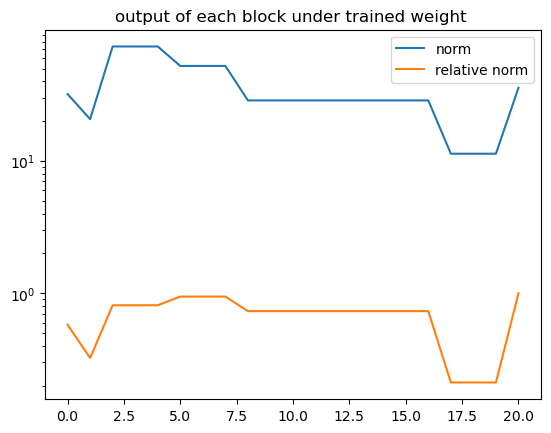

In [81]:
plt.plot(xnorm)
plt.plot(xrelnorm)
plt.legend(["norm",'relative norm'])
plt.yscale('log')
plt.title('output of each block under trained weight ')

In [82]:
inputx=keras.Input((None,None,3))
x=modified_efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
ModifiedMymodel=keras.Model(inputs=inputx,outputs=x)

inputx=keras.Input((None,None,3))
x=efficientv2_base(inputx)
x=keras.layers.Dense(10,activation='softmax')(x)
Mymodel=keras.Model(inputs=inputx,outputs=x)

In [87]:
xx=np.random.randn(10000,32,32,3)
yy=np.random.randn(10000,10)

In [90]:
test_running(xx,yy,Mymodel)
test_running(xx,yy,ModifiedMymodel)

Average running time: 27.450 ms ± 0.206 ms / batch
Average running time: 38.057 ms ± 0.574 ms / batch
